In [ ]:
import os 
import shutil


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# shutil.copy('/content/drive/MyDrive/Colab Notebooks/APL_TASK/Compose/enron-email-dataset.zip','./')
shutil.copy('/content/drive/MyDrive/Colab Notebooks/APL_TASK/Compose/enron.zip','./')


In [ ]:
from zipfile import ZipFile
name= 'enron.zip'
with ZipFile(name, 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall()


In [ ]:
import pandas as pd

In [ ]:
emails_df = pd.read_csv('./emails.csv')

In [ ]:
print(emails_df.shape)
emails_df.head()

(517401, 2)


,file,message
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...


In [ ]:
print(emails_df['message'][0])

Message-ID: <18782981.1075855378110.JavaMail.evans@thyme>
Date: Mon, 14 May 2001 16:39:00 -0700 (PDT)
From: phillip.allen@enron.com
To: tim.belden@enron.com
Subject: 
Mime-Version: 1.0
Content-Type: text/plain; charset=us-ascii
Content-Transfer-Encoding: 7bit
X-From: Phillip K Allen
X-To: Tim Belden <Tim Belden/Enron@EnronXGate>
X-cc: 
X-bcc: 
X-Folder: \Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Sent Mail
X-Origin: Allen-P
X-FileName: pallen (Non-Privileged).pst

Here is our forecast

 


In [ ]:
import email
import re
import numpy as np

In [ ]:
# Convert to message objects from the message strings
messages = list(map(email.message_from_string, emails_df['message']))

In [ ]:
def get_text_from_email(msg):
  parts = []
  for part in msg.walk():
      if part.get_content_type() == 'text/plain':
          parts.append( part.get_payload() )
  text = ''.join(parts)
  return text

emails = pd.DataFrame()

# Parse content from emails
emails['content'] = list(map(get_text_from_email, messages))

In [ ]:
emails

,content
0,Here is our forecast\n\n
1,Traveling to have a business meeting takes the...
2,test successful. way to go!!!
3,"Randy,\n\n Can you send me a schedule of the s..."
4,Let's shoot for Tuesday at 11:45.
...,...
517396,This is a trade with OIL-SPEC-HEDGE-NG (John L...
517397,Some of my position is with the Alberta Term b...
517398,2\n\n -----Original Message-----\nFrom: \tDouc...
517399,Analyst\t\t\t\t\tRank\n\nStephane Brodeur\t\t\...


In [ ]:
import gc

# Remove variables from memory
del messages
del emails_df
gc.collect()

12

In [ ]:
def normalize_text(text):
  text = text.lower()
  
  # creating a space between a word and the punctuation following it to separate words
  # and compact repetition of punctuation
  # eg: "he is a boy.." => "he is a boy ."
  text = re.sub(r'([.,!?]+)', r" \1 ", text)

  # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",", "'")
  text = re.sub(r"[^a-zA-Z?.!,']+", " ", text)

  # Compact spaces
  text = re.sub(r'[" "]+', " ", text)

  # Remove forwarded messages
  text = text.split('forwarded by')[0]

  text = text.strip()

  return text

emails['content'] = list(map(normalize_text, emails['content']))

In [ ]:
# Drop samples with empty content text after normalization
emails['content'].replace('', np.nan, inplace=True)
emails.dropna(subset=['content'], inplace=True)

In [ ]:
emails

,content
0,here is our forecast
1,traveling to have a business meeting takes the...
2,test successful . way to go !!!
3,"randy , can you send me a schedule of the sala..."
4,let's shoot for tuesday at .
...,...
517396,this is a trade with oil spec hedge ng john la...
517397,some of my position is with the alberta term b...
517398,"original message from doucet , dawn sent wedne..."
517399,analyst rank stephane brodeur chad clark ian c...


In [ ]:
SENTENCE_MAX_WORDS = 20
def generate_dataset(contents):
    output = []
    vocabulary_sentences = []

    for content in contents:
        if (len(content) > SENTENCE_MAX_WORDS * 5): continue
        sentences = content.split(' . ')
        for sentence in sentences:
            sentence = re.sub("(^\w+\s,\s)|(\s,\s\w+$)", "", sentence)
            words = sentence.split(' ')
            if ((len(words) > SENTENCE_MAX_WORDS) or (len(words) < 2)): continue
            
            vocabulary_sentences.append('<start> ' + sentence + ' <end>')

            for i in range(1, len(sentence)):
                data = []
                x_ngram = '<start> '+ sentence[:i+1] + ' <end>'
                y_ngram = '<start> '+ sentence[i+1:] + ' <end>'
                output.append([x_ngram,y_ngram])

    return output, vocabulary_sentences   

In [ ]:
pairs,vocabulary_sentences = generate_dataset(emails.content)

In [ ]:
print(len(pairs))
print(len(vocabulary_sentences))


3455994
104151


In [ ]:
print(*pairs[:10], sep='\n')
print(*vocabulary_sentences[:10], sep='\n')

['<start> he <end>', '<start> re is our forecast <end>']
['<start> her <end>', '<start> e is our forecast <end>']
['<start> here <end>', '<start>  is our forecast <end>']
['<start> here  <end>', '<start> is our forecast <end>']
['<start> here i <end>', '<start> s our forecast <end>']
['<start> here is <end>', '<start>  our forecast <end>']
['<start> here is  <end>', '<start> our forecast <end>']
['<start> here is o <end>', '<start> ur forecast <end>']
['<start> here is ou <end>', '<start> r forecast <end>']
['<start> here is our <end>', '<start>  forecast <end>']
<start> here is our forecast <end>
<start> test successful <end>
<start> way to go !!! <end>
<start> let's shoot for tuesday at . <end>
<start> how about either next tuesday or thursday ? phillip <end>
<start> any morning between and <end>
<start> million is fine phillip <end>
<start> i think fletch has a good cpa <end>
<start> i am still doing my own . <end>
<start> nymex expiration is during this time frame <end>


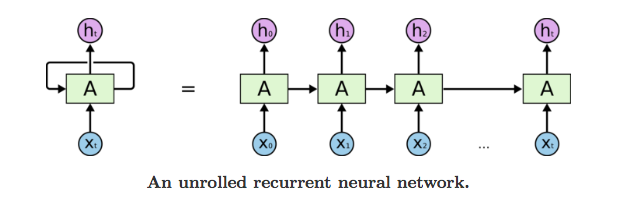

In [ ]:
from PIL import Image
filepath = 'drive//My Drive//Colab Notebooks//APL_TASK//Compose//Google Smart Compose//'
Image.open(filepath+'RNN.png')

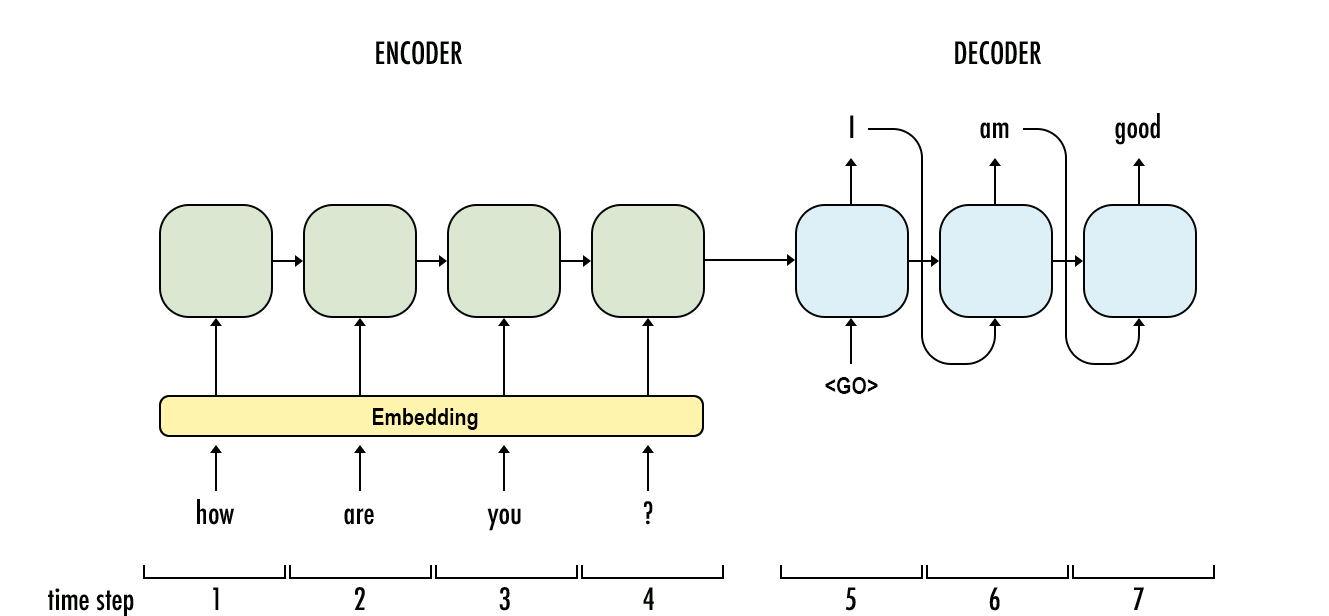

In [ ]:
Image.open(filepath+'seq2seq.png')

In [ ]:
# https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html

In [ ]:
import tensorflow as tf
from tensorflow.compat.v1 import keras
from tensorflow.compat.v1.keras.models import Model
from tensorflow.compat.v1.keras.layers import Input, LSTM, Dense, Embedding, CuDNNLSTM, Flatten, TimeDistributed, Dropout, LSTMCell, RNN, Bidirectional, Concatenate, Layer
from tensorflow.compat.v1.keras.callbacks import ModelCheckpoint , CSVLogger

np.random.seed(42)


In [ ]:
vocab_max_size = 10000

def tokenize(text):
  tokenizer = keras.preprocessing.text.Tokenizer(filters='', num_words=vocab_max_size)
  tokenizer.fit_on_texts(text)

  return tokenizer


In [ ]:
input_lang  = [inp for inp , out in pairs]
target_lang = [out for inp , out in pairs]

tokenizer = tokenize(vocabulary_sentences)

input_data   = tokenizer.texts_to_sequences(input_lang)
teacher_data = tokenizer.texts_to_sequences(target_lang)
target_data  = [
                [teacher_data[n][i+1]
                    for i in range(len(teacher_data[n])-1)]
                        for n in range(len(teacher_data))
               ]

# Convert to np.array
input_data   = np.array(input_data)
teacher_data = np.array(teacher_data)
target_data  = np.array(target_data)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this,

In [ ]:
print('input_data shape   :', input_data.shape)
print('teacher_data shape :', teacher_data.shape)
print('target_data shape  :', target_data.shape)

input_data shape   : (3455994,)
teacher_data shape : (3455994,)
target_data shape  : (3455994,)


In [ ]:
def max_length(t):
    return max(len(i) for i in t)

max_length_in = max_length(input_data)
max_length_out = max_length(teacher_data)
max_length_in,max_length_out

(22, 22)

In [ ]:
input_data   = keras.preprocessing.sequence.pad_sequences(input_data,  maxlen=max_length_in,  padding="post")
teacher_data = keras.preprocessing.sequence.pad_sequences(teacher_data,maxlen=max_length_out, padding="post")
target_data  = keras.preprocessing.sequence.pad_sequences(target_data, maxlen=max_length_out, padding="post")



In [ ]:
# Shuffle the data in unison
p = np.random.permutation(len(input_data))
input_data = input_data[p]
teacher_data = teacher_data[p]
target_data = target_data[p]



In [ ]:
EPOCHS        = 10
BATCH_SIZE    = 128
embedding_dim = 300
units         = 128
vocab_size    = len(tokenizer.word_index)


In [ ]:
test = "_test1_"
model_name = "SmartComposeCuDNNLSTM"
filepath = 'drive//My Drive//Colab Notebooks//APL_TASK//Compose//Google Smart Compose//'+model_name+'//'+test[1:-1]+'//'
os.makedirs(filepath,exist_ok=True)

model_name = model_name+test


In [ ]:
######## DEFINING LSTM ENCODER AND DECODER MODEL #########

# Create the Encoder layers first.
encoder_inputs = Input(shape=(max_length_in,))
encoder_emb    = Embedding(input_dim=vocab_size, output_dim=embedding_dim)
encoder_lstm   = CuDNNLSTM(units=units, return_sequences=True, return_state=True)


encoder_out, fstate_h, bstate_h= encoder_lstm(encoder_emb(encoder_inputs))
# state_h = Concatenate()([fstate_h,bstate_h])
# state_c = Concatenate()([bstate_h,bstate_c])
encoder_states = [state_h, state_c]


# Now create the Decoder layers.
decoder_inputs = Input(shape=(None,))
decoder_emb    = Embedding(input_dim=vocab_size, output_dim=embedding_dim)
decoder_lstm   = CuDNNLSTM(units=units*2, return_sequences=True, return_state=True)


decoder_lstm_out, _, _ = decoder_lstm(decoder_emb(decoder_inputs), initial_state=encoder_states)


# Two dense layers added to this model to improve inference capabilities.
decoder_d1  = Dense(units, activation="relu")
decoder_d2  = Dense(vocab_size, activation="softmax")
decoder_out = decoder_d2(Dropout(rate=.2)(decoder_d1(Dropout(rate=.2)(decoder_lstm_out))))

def perplexity(y_true, y_pred):
    return keras.backend.exp(keras.backend.mean(keras.backend.sparse_categorical_crossentropy(y_true, y_pred)))

model = Model(inputs = [encoder_inputs, decoder_inputs], outputs= decoder_out)
model.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=[perplexity])
model.summary()

if True:
    for layer in model.layers:
        layer.trainable = True
    model.load_weights(filepath+model_name+'weights.best.hdf5')


Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 22)]         0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 22, 300)      4742700     input_7[0][0]                    
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
bidirectional_3 (Bidirectional) [(None, 22, 256), (N 440320      embedding_6[0][0]                
____________________________________________________________________________________________

In [ ]:
csv_logger = CSVLogger(filepath+model_name+'training.log', append=True, )
checkpoint = ModelCheckpoint(filepath+model_name+'weights.best.hdf5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint,csv_logger]

history = model.fit([input_data, teacher_data], target_data,
                 batch_size= BATCH_SIZE,
                #  steps_per_epoch=len(input_data) // BATCH_SIZE,
                 epochs=EPOCHS,
                 callbacks=callbacks_list,
                 validation_split=0.2,)

Epoch 1/10
21600/21600 [==============================] - 1761s 81ms/step - loss: 0.3892 - perplexity: 1.4765 - val_loss: 0.3179 - val_perplexity: 1.3748

Epoch 00001: val_loss improved from inf to 0.31793, saving model to drive//My Drive//Colab Notebooks//APL_TASK//Compose//Google Smart Compose//SmartComposeCuDNNLSTM//test1/SmartComposeCuDNNLSTM_test1_weights.best.hdf5
Epoch 2/10
21600/21600 [==============================] - 1830s 85ms/step - loss: 0.3843 - perplexity: 1.4693 - val_loss: 0.3131 - val_perplexity: 1.3682

Epoch 00002: val_loss improved from 0.31793 to 0.31313, saving model to drive//My Drive//Colab Notebooks//APL_TASK//Compose//Google Smart Compose//SmartComposeCuDNNLSTM//test1/SmartComposeCuDNNLSTM_test1_weights.best.hdf5
Epoch 3/10
21600/21600 [==============================] - 1818s 84ms/step - loss: 0.3800 - perplexity: 1.4631 - val_loss: 0.3103 - val_perplexity: 1.3643

Epoch 00003: val_loss improved from 0.31313 to 0.31033, saving model to drive//My Drive//Colab 

In [ ]:
#### INFERENCE MODEL ####


# Create the encoder model from the tensors we previously declared.
encoder_model = Model(encoder_inputs, [encoder_out, state_h, state_c])


inf_decoder_inputs = Input(shape=(None,), name="inf_decoder_inputs")


state_input_h = Input(shape=(units*2,), name="state_input_h")
state_input_c = Input(shape=(units*2,), name="state_input_c")

decoder_res, decoder_h, decoder_c = decoder_lstm(decoder_emb(inf_decoder_inputs) , initial_state=[state_input_h, state_input_c])
inf_decoder_out = decoder_d2(decoder_d1(decoder_res))

inf_model = Model(inputs=[inf_decoder_inputs, state_input_h, state_input_c], outputs=[inf_decoder_out, decoder_h, decoder_c])

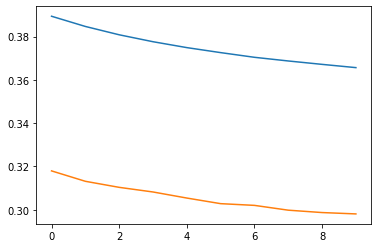

In [ ]:
# Plot the results of the training.
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label="Training loss")
plt.plot(history.history['val_loss'], label="Validation loss")
plt.show()

In [ ]:
# save plot to disk
plt.savefig(filepath+model_name+'plot.png')

<Figure size 432x288 with 0 Axes>

In [ ]:
# to find the index of higher validation accuracy
# np.argmin(H.history['val_loss'])+1

In [ ]:
inf_model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inf_decoder_inputs (InputLayer) [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, None, 300)    4742700     inf_decoder_inputs[0][0]         
__________________________________________________________________________________________________
state_input_h (InputLayer)      [(None, 256)]        0                                            
__________________________________________________________________________________________________
state_input_c (InputLayer)      [(None, 256)]        0                                            
____________________________________________________________________________________________

In [ ]:
import pickle
print(pickle.format_version)

4.0


In [ ]:
# save the ENCODER & INFERENCE MODEL to disk
import json 

with open(filepath+model_name+ 'word_dict-final.json' , 'w' ) as file:    
    json.dump( tokenizer.word_index , file)

# saving pickle for tokenizer
with open(filepath+model_name+ 'tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

model.save(filepath+model_name+'save_model.h5')

encoder_model.save(filepath+model_name+'encoder-model-final.h5')
inf_model.save(filepath+model_name+'inf-model-final.h5')


In [ ]:
import tensorflow as tf
tf.test.is_gpu_available()

True

In [ ]:
test = "_test1_"
model_name = "SmartComposeCuDNNLSTM"
filepath = 'drive//My Drive//Colab Notebooks//APL_TASK//Compose//Google Smart Compose//'+model_name+'//'+test[1:-1]+'//'
# os.makedirs(filepath,exist_ok=True)

model_name = model_name+test

In [ ]:
import pickle
print(pickle.format_version)
# loading
with open(filepath+model_name+ 'tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

4.0


In [ ]:
########### REAL TIME INFERENCE ###########

from tensorflow.compat.v1.keras.models import load_model
from tensorflow.compat.v1 import keras
import numpy as np

max_length_in  = 22
max_length_out = 22

encoder_model = load_model(filepath+model_name+'encoder-model-final.h5')
inf_model     = load_model(filepath+model_name+'inf-model-final.h5')

def tokenize_text(text):
    text = '<start> ' + text.lower() + ' <end>'
    text_tensor = tokenizer.texts_to_sequences([text])
    text_tensor = keras.preprocessing.sequence.pad_sequences(text_tensor, maxlen=max_length_in, padding="post")
    return text_tensor


def translate(input_text):
    input_text        = tokenize_text(input_text)
    [emb_out, sh, sc] = encoder_model.predict(input_text)
    target_seq        = np.zeros((1, 1))
    target_seq[0, 0]  = tokenizer.word_index['<start>']
    curr_word         = "<start>"
    decoded_sentence  = ''
    index_to_word     = dict(map(reversed, tokenizer.word_index.items()))
    current_index     = 0

    while curr_word != "<end>" and current_index < (max_length_out - 1):

        [output_tokens, h, c] = inf_model.predict([target_seq, sh, sc])
        target_seq[0,0]       = np.argmax(output_tokens[0,0])
        
        if (target_seq[0,0] == 0):break
        
        curr_word        = index_to_word[target_seq[0,0]]
        decoded_sentence += " " + curr_word
        sh,sc            = h,c
        current_index    += 1
    return decoded_sentence

In [ ]:
import ipywidgets as widgets


In [ ]:
outputBox = widgets.Text()
inputBox = widgets.Text()

def run_inference(sender):
    outputBox.value = translate(inputBox.value)


outputBox

Text(value='')

In [ ]:
inputBox.on_submit(run_inference)
inputBox

Text(value='')

In [ ]:
# from pynput.mouse import Button, Controller
#    ...: import time
#    ...:
#    ...: mouse = Controller()
#    ...:
#    ...: while True:
#    ...:     mouse.click(Button.left, 1)
#    ...:     time.sleep(120)
#    ...:

In [ ]:
# from PIL import ImageGrab
# import numpy as np
# import cv2
# import time

# time.sleep(5)

# SCREEN_SIZE = (490, 400#335)

# # define the codec
# fourcc = cv2.VideoWriter_fourcc(*"XVID")

# # create the video write object
# out = cv2.VideoWriter("output.avi", fourcc, 20.0, (SCREEN_SIZE))

# while True:
#     img = ImageGrab.grab(bbox=(10,100,500,500))
#     frame = np.array(img)
#     frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
#     out.write(frame)
#     cv2.imshow("screenshot", frame)
#     if cv2.waitKey(1) == ord("q"):
#         break

# cv2.destroyAllWindows()
# out.release()

In [ ]:
# let me know i
# is it o
# i wi
# i will
# i will be o
# please
# please be
# please re
# please call m
# this sounds good
# it should
# it should be a gre
# is this call going